In [159]:
import pandas as pd # pandas is a data manipulation library
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import matplotlib.pyplot as plt # data visualization library
from sklearn import datasets
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA

# Exercise: k-means Initialization

We use for the evaluation of the correct answer seed fixing for random generators in sklearn and numpy. Hence, make sure that you have the newest versions (sklearn version 1.2.0 and numpy version 1.24.1).

In [160]:
!pip3 show scikit-learn

Name: scikit-learn
Version: 1.2.0
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /home/igor/.local/lib/python3.10/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: flair, sklearn


In [161]:
!pip3 show numpy

Name: numpy
Version: 1.24.1
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: /home/igor/.local/lib/python3.10/site-packages
Requires: 
Required-by: blis, bpemb, datasets, gensim, hyperopt, matplotlib, pandas, patsy, plotly-express, pyarrow, scikit-learn, scipy, seaborn, spacy, statsmodels, thinc, transformers, xgboost


If your versions don't match, the following commands (or their anaconda version) could help to get the newest stable release. If you need help with this, please ask the TAs during instruction hours.

In [162]:
!pip3 install scikit-learn --upgrade
!pip3 install numpy --upgrade

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


The functions generating the datasets are given here:

In [163]:
def generateMoons(epsilon, n):
    moons, labels = datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    return moons, labels, 2
def generateBlobs(epsilon, n):
    blobs, labels = datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 1.5, epsilon + 0.5], random_state=54)
    return blobs, labels, 3
def generateAniso(epsilon,n):
    # Anisotropicly distributed data
    A, labels = datasets.make_blobs(n_samples=n, random_state=170)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    aniso = np.dot(A, transformation)
    return aniso, labels, 3

Implement the centroid initialization here. Right now, it returns a random sample from the datapoints. 

In [164]:
def init_centroids_greedy_pp(D,r,l=10):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param l: (int) number of centroid candidates in each step
        :return: (np-array) 'X' the selected centroids from the dataset
    '''   
    #Do not change the seed
    rng =  np.random.default_rng(seed=7) # use this random generator to sample the candidates (sampling according to given probabilities can be done via rng.choice(..))
    n,d = D.shape

    indexes = rng.integers(low=0, high=n, size=r)
    X = np.array(D[indexes,:]).T
    return X

This is the $k$-means implementation from the lecture accompanying notebook.

In [165]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)

In [166]:
def getY(labels):
    '''
        Compute the cluster assignment matrix Y from the categorically encoded labels
    '''
    Y = np.eye(max(labels)+1)[labels]
    return Y
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

We generate the datasets.

In [167]:
n=500
D_blobs, labels_blobs, r_blobs = generateBlobs(0.05,n)
D_moons, labels_moons, r_moons = generateMoons(0.05,n)
D_aniso, labels_aniso, r_aniso = generateAniso(0.05,n)

In [168]:
D, labels, r = D_blobs, labels_blobs, r_blobs
X_init = init_centroids_greedy_pp(D,r)
X,Y = kmeans(D,r, X_init)

6 iterations


Plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue.

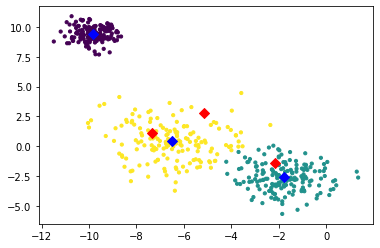

In [169]:
fig = plt.figure()
plt.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
plt.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D')
plt.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D')

# Exercise: Decision tree

In [170]:
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

Load the data

In [171]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

Splitting the data - 80:20 ratio

Use also for this exercise the latest stable version of sklearn because of the use of the random generator for the train and test split

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)
print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (120, 4)
Testing split input-  (30, 4)


Function to visualize the decision tree (the argument is a fitted sklearn DecisionTreeClassifier)

In [173]:
def plot_iris_tree(decision_tree):
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
    tree.plot_tree(decision_tree=decision_tree, feature_names = ["sepal_length","sepal_width","petal_length","petal_width"], 
                     class_names =["setosa", "versicolor", "verginica"] , filled = True , precision = 2, rounded = True)

# Exercise : Stochastic Gradient Descent

Scikit learn provides two classes `SGDRegressor` and `SGDClassifier` which use stochastic gradient descent to carry out linear regression and classification respectively.

These models are especially useful in these situations:
- with very large datasets
- with streaming data (they support online learning)
- with datasets with sparse features

SGD is sensitive to learning rate and the scale of the features. It's advisable to z-score the features, and to tune the learning rate.

In [174]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error

We'll use the dataset of 50,000 songs. The prediction task is to guess the year the song was made based on 90 timbre features extracted from the audio. The year is in the first column.

In [175]:
songs = np.load("songs50k.npy")
X_train, X_val, y_train, y_val = train_test_split(songs[:,1:], songs[:,0], test_size=1/3, random_state=10)

Train and evaluate the SGD classifier on the songs dataset. Take the following steps:
- z-score the training and validation features
- find good settings for learning rate type and learning rate initial value.
  - r-squared on validation data 
  - mean absolute error on validation data  

We scale the data using the StandardScaler

In [176]:
scaler=StandardScaler()
X_train_sc=scaler.fit_transform(X_train)
X_val_sc=scaler.transform(X_val)

Use also for this exercise the latest stable version of sklearn because of the use of the random generator for the train and test split.

Use the SGDRegressor with a random state of 123, that is evaluate the parameter settings like this:

In [177]:
learning_rate="optimal"
eta0=1
model = SGDRegressor(learning_rate=learning_rate,eta0=eta0,random_state=123)
model.fit(X_train_sc, y_train)

SGDRegressor(eta0=1, learning_rate='optimal', random_state=123)

By default SGDRegressor tries to minimize the standard linear regression error function, that is sum of squared error. However this can be changed, via the `loss=` parameter. When `loss='squared_loss'`, sum of squared errors will be used. Other error functions available include [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) (`loss='huber'`). Compared to squared loss, huber focuses less on outliers.

# Exercise : Latent Space

In [178]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

The method `scatter_pictures` displays a scatter plot where the coordinates are given by `Y` and the data points are visualized by pictures of the faces defined in `D_approx`. You can try using `D_approx=D` as argument or you could insert the approximation of the pictures as computed by the low-rank matrix factorization (SVD) into `D_approx`.

In [179]:
def scatter_pictures(D_approx, Y):
    zoom = 0.4
    fig, ax = plt.subplots(figsize=(16,16))
    for i in range(D.shape[0]):
        image = D_approx[i,:].reshape((64, 64))
        im = OffsetImage(image, cmap=plt.cm.gray,zoom=zoom)
        ab = AnnotationBbox(im, (Y[i,0], Y[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Y[i,0], Y[i,1])])
        ax.autoscale()

In [180]:
faces = fetch_olivetti_faces()
D = faces.data

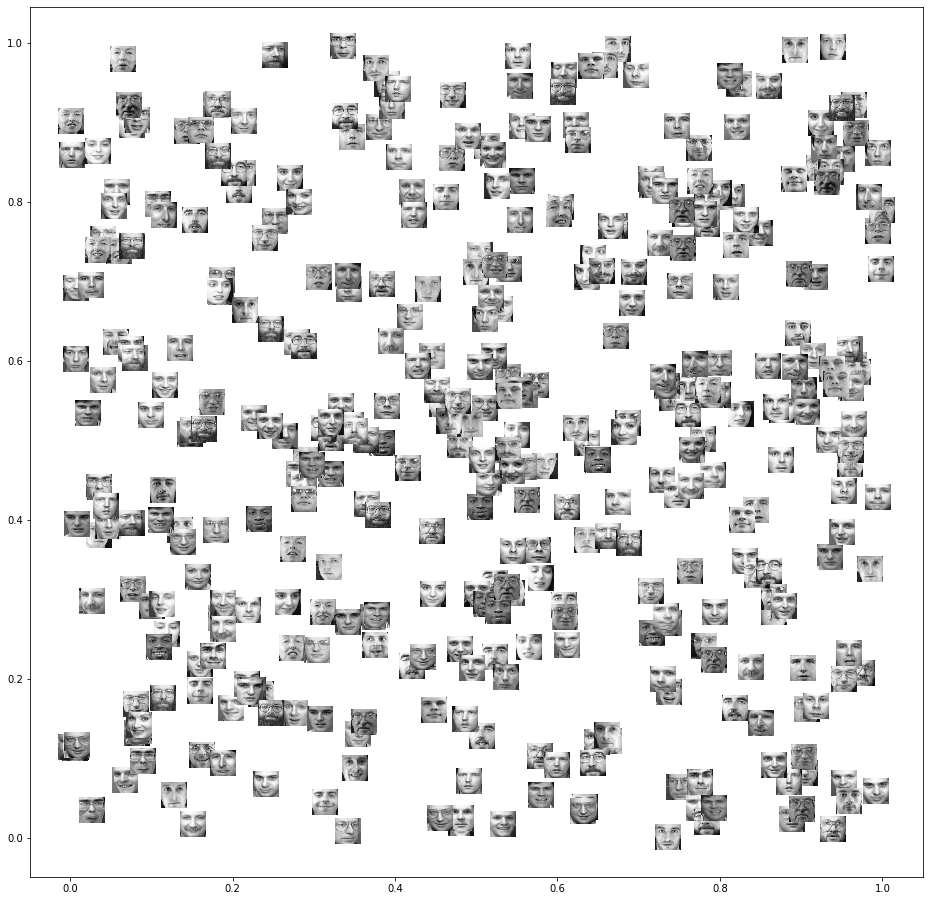

In [181]:
scatter_pictures(D, np.random.rand(D.shape[0],2))

## 5

In [182]:
r=2
U, s, V = np.linalg.svd(D,full_matrices=True)
Y=U[:,0:r]*np.sqrt(s[0:r])
X=V.T[:,0:r]*np.sqrt(s[0:r])
D_trunc = Y@X.T
scatter_pictures(D_trunc,Y)

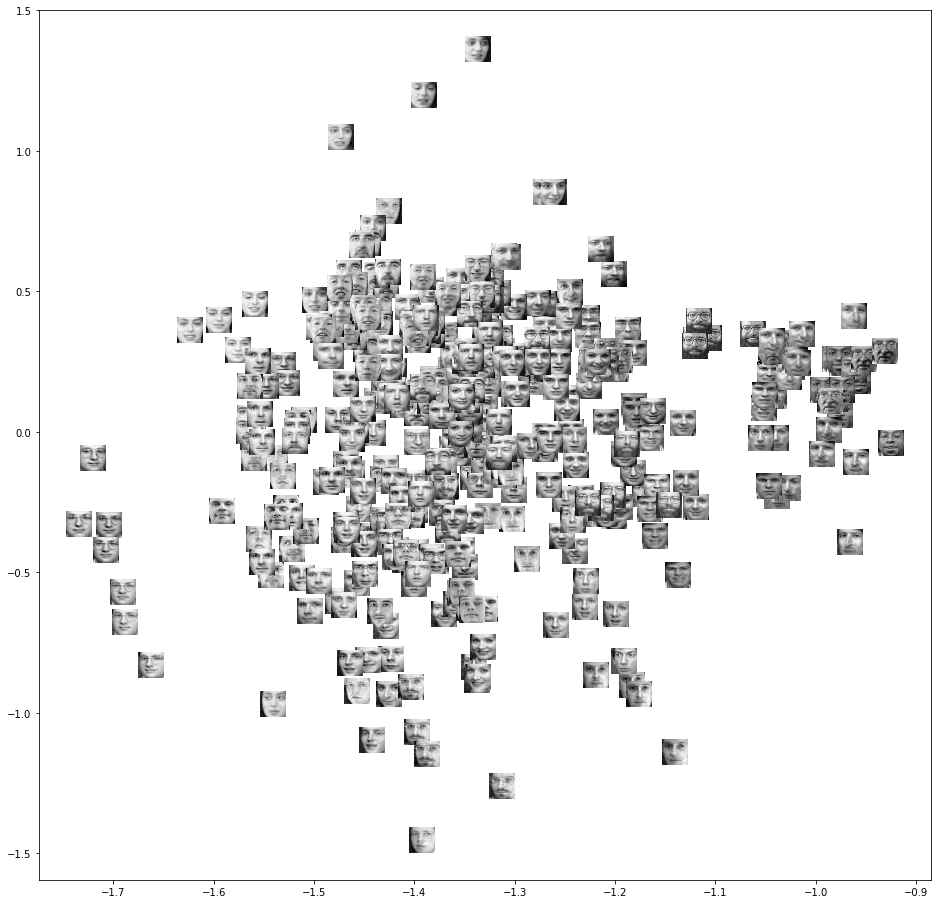

In [ ]:
r=100
U, s, V = np.linalg.svd(D,full_matrices=True)
Y=U[:,0:r]*np.sqrt(s[0:r])
X=V.T[:,0:r]*np.sqrt(s[0:r])
D_trunc = Y@X.T
scatter_pictures(D_trunc,Y)

From the visualization with r=2 we can see that one of the features corresponds to whether light is coming from left or right side of the picture (Y-axis). The other axis can only be distincted when r is much higher - like r=100. Then we can instantly notice that pictures on the right represent people with darker skin tone, less light, or dark facial hair, while on the left we can only see caucasians without any hair in the frame and high exposition of the picture.

- X-axis - Overall amount of light/dark pixels (e.g. skin tone, black hair, picture exposition)
- Y-axis - light on left/right

Latent space (Y) represents feature intensity in specific pictures. First column represents how bright the picture is - the higher the value, the brighter it is. Second column informs how skewed to the left the origin of light is - the higher the value, the more light we see coming from the left side andless from the right side.